In [2]:
from __future__ import annotations
import argparse
import math
import re
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple


import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# ------------------------
# Parsing utilities
# ------------------------

def infer_context_length(run_name: str, model_name: Optional[str]) -> Optional[int]:
    """Infer context length from run directory or model name.

    Examples of supported patterns:
      - "tabpfn-ts-500cntx-run2-fixed" -> 500
      - "tabpfn-ts-6000cntx" -> 6000
      - *paper* (baseline/original) -> 4096
    """
    if run_name is None:
        return None
    # Extract like "500cntx" (case-insensitive)
    m = re.search(r"(\d{2,5})\s*cntx", run_name, flags=re.IGNORECASE)
    if m:
        try:
            return int(m.group(1))
        except ValueError:
            pass
    # Fallback: try model name
    if model_name:
        m2 = re.search(r"(\d{2,5})\s*cntx", model_name, flags=re.IGNORECASE)
        if m2:
            try:
                return int(m2.group(1))
            except ValueError:
                pass
    # Paper baseline
    if "paper" in (run_name or "").lower() or (model_name and "paper" in model_name.lower()):
        return 4096
    return None


def parse_dataset_path_field(ds: str) -> Tuple[str, str, str, str]:
    """Parse dataset string from the CSV into (dataset_root, subset, term, panel_key).

    Examples:
      "bizitobs_service/10S/short" -> ("bizitobs_service", "10S", "short", "bizitobs_service/10S")
      "hierarchical_sales/D/long"  -> ("hierarchical_sales", "D",   "long",  "hierarchical_sales/D")
      "M_DENSE/H/medium"           -> ("M_DENSE",           "H",   "medium","M_DENSE/H")
    """
    if not isinstance(ds, str) or not ds:
        return ("", "", "", "/")
    parts = ds.split("/")
    term = parts[-1] if len(parts) >= 1 else ""
    subset = parts[-2] if len(parts) >= 2 else ""
    if len(parts) >= 3:
        dataset_root = "/".join(parts[:-2])
    else:
        dataset_root = parts[0] if parts else ""
    panel_key = f"{dataset_root}/{subset}" if subset else dataset_root
    return dataset_root, subset, term, panel_key



In [7]:
def infer_context_length(run_name: str, model_name: Optional[str]) -> Optional[int]:
    """
    Infer context length from run directory or model name.

    Examples:
      - "tabpfn-ts-500cntx-run2-fixed" -> 500
      - "tabpfn-ts-6000cntx" -> 6000
      - "*paper*" (baseline/original) -> 4096
    """
    if run_name:
        m = re.search(r"(\d{2,5})\s*cntx", run_name, flags=re.IGNORECASE)
        if m:
            try:
                return int(m.group(1))
            except ValueError:
                pass
    if model_name:
        m2 = re.search(r"(\d{2,5})\s*cntx", model_name, flags=re.IGNORECASE)
        if m2:
            try:
                return int(m2.group(1))
            except ValueError:
                pass
    if (run_name and "paper" in run_name.lower()) or (model_name and "paper" in model_name.lower()):
        return 4096
    return None


def parse_dataset_path_field(ds: str) -> Tuple[str, str, str, str]:
    """
    Parse CSV 'dataset' (e.g., "bizitobs_service/10S/short") into:
      (dataset_root, subset, term, panel_key)
    panel_key groups dataset+subset (e.g., "bizitobs_service/10S").
    """
    if not isinstance(ds, str) or not ds:
        return ("", "", "", "/")
    parts = ds.split("/")
    term = parts[-1] if len(parts) >= 1 else ""
    subset = parts[-2] if len(parts) >= 2 else ""
    dataset_root = "/".join(parts[:-2]) if len(parts) >= 3 else (parts[0] if parts else "")
    panel_key = f"{dataset_root}/{subset}" if subset else dataset_root
    return dataset_root, subset, term, panel_key


def sanitize_filename(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", s)


In [12]:
def discover_results(root: Path) -> List[Path]:
    return sorted(root.rglob("results.csv"))

def load_results(root: Path) -> pd.DataFrame:
    rows: List[pd.DataFrame] = []
    empty_files: List[str] = []
    missing_dataset: List[str] = []

    for fpath in discover_results(root):
        rel = fpath.relative_to(root) if fpath.is_relative_to(root) else fpath
        run_name = rel.parts[0] if len(rel.parts) >= 1 else ""

        try:
            df = pd.read_csv(fpath)
        except Exception as e:
            print(f"[WARN] Failed to read {fpath}: {e}")
            continue

        # Skip empty CSVs early
        if df.empty:
            empty_files.append(str(fpath))
            continue

        if "dataset" not in df.columns:
            missing_dataset.append(str(fpath))
            continue

        # Model name (optional) — use iloc to be position-safe
        model_name = None
        if "model" in df.columns and not df.empty:
            first_model_val = df["model"].iloc[0]
            if isinstance(first_model_val, str):
                model_name = first_model_val

        ctx = infer_context_length(run_name, model_name)

        df["run_name"] = run_name
        df["context_length"] = ctx

        parsed = df["dataset"].apply(parse_dataset_path_field)
        df[["dataset_root", "subset", "term", "panel_key"]] = pd.DataFrame(parsed.tolist(), index=df.index)
        df["source_csv"] = str(fpath)
        rows.append(df)

    if empty_files:
        print(f"[WARN] {len(empty_files)} empty results.csv skipped (showing up to 5):")
        for p in empty_files[:5]:
            print("   -", p)

    if missing_dataset:
        print(f"[WARN] {len(missing_dataset)} results.csv without 'dataset' column skipped (up to 5):")
        for p in missing_dataset[:5]:
            print("   -", p)

    if not rows:
        raise RuntimeError(f"No usable results.csv files found under {root}")
    return pd.concat(rows, ignore_index=True)


In [10]:
# ---- User config (EDIT THESE) ----
ROOT = Path("/home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results").expanduser()  # folder that contains run dirs (e.g., tabpfn-ts-500cntx-*, tabpfn-ts-paper)
METRIC = "eval_metrics/sMAPE[0.5]"                 # e.g., "eval_metrics/MASE[0.5]", "eval_metrics/NRMSE[mean]", "eval_metrics/ND[0.5]"
AGG = "mean"                                     # "median" or "mean"
TERMS = ["short", "medium", "long"]                # horizons to plot
PANELS_FILTER = []                                 # optional: e.g., ["hierarchical_sales/D","LOOP_SEATTLE/D"]; leave [] for all
SAVE_DIR = Path("figures")                         # where to save figures + tidy csv
YLOG = False                                       # set True to log-scale y-axis
MAX_COLS = 3             

In [17]:
from collections import Counter

all_csvs = discover_results(ROOT)
print(f"Found {len(all_csvs)} results.csv files")
empty, no_dataset, ok = [], [], []
for p in all_csvs:
    try:
        tmp = pd.read_csv(p)
    except Exception:
        continue
    if tmp.empty:
        empty.append(str(p))
    elif "dataset" not in tmp.columns:
        no_dataset.append(str(p))
    else:
        ok.append(str(p))

print(f"Empty: {len(empty)} | Missing 'dataset': {len(no_dataset)} | OK: {len(ok)}")
for p in empty[:5]:
    print("  [empty] ", p)
for p in no_dataset[:5]:
    print("  [no ds ]", p)


Found 420 results.csv files
Empty: 5 | Missing 'dataset': 0 | OK: 415
  [empty]  /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-2000cntx-run3-fixed/SZ_TAXI/15T/results.csv
  [empty]  /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-200cntx-run2/bitbrains_rnd/H/results.csv
  [empty]  /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-300cntx-run3/bitbrains_fast_storage/H/results.csv
  [empty]  /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-paper/LOOP_SEATTLE/5T/results.csv
  [empty]  /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-paper/LOOP_SEATTLE/H/results.csv


In [13]:
print(f"[INFO] Loading results from {ROOT} ...")
raw_df = load_results(ROOT)
print(f"[INFO] Loaded {len(raw_df)} rows from {raw_df['source_csv'].nunique()} CSV files.")
raw_df.head()


[INFO] Loading results from /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results ...
[WARN] 5 empty results.csv skipped (showing up to 5):
   - /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-2000cntx-run3-fixed/SZ_TAXI/15T/results.csv
   - /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-200cntx-run2/bitbrains_rnd/H/results.csv
   - /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-300cntx-run3/bitbrains_fast_storage/H/results.csv
   - /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-paper/LOOP_SEATTLE/5T/results.csv
   - /home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/results/tabpfn-ts-paper/LOOP_SEATTLE/H/results.csv
[INFO] Loaded 759 rows from 415 CSV files.


,dataset,model,eval_metrics/MSE[mean],eval_metrics/MSE[0.5],eval_metrics/MAE[0.5],eval_metrics/MASE[0.5],eval_metrics/MAPE[0.5],eval_metrics/sMAPE[0.5],eval_metrics/MSIS,eval_metrics/RMSE[mean],...,eval_metrics/mean_weighted_sum_quantile_loss,domain,num_variates,run_name,context_length,dataset_root,subset,term,panel_key,source_csv
0,loop_seattle/D/short,tabpfn-ts-1000cntx,19.576248,19.576248,3.049182,0.914210,0.057552,0.056244,7.298306,4.424505,...,0.043664,Transport,1,tabpfn-ts-1000cntx,1000,loop_seattle,D,short,loop_seattle/D,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...
1,m_dense/D/short,tabpfn-ts-1000cntx,7560.043704,7560.043704,42.817431,0.688203,0.121499,0.099075,6.464766,86.948512,...,0.061538,Transport,1,tabpfn-ts-1000cntx,1000,m_dense,D,short,m_dense/D,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...
2,m_dense/H/short,tabpfn-ts-1000cntx,65040.408194,65040.408194,108.145251,0.935143,0.313693,0.246281,9.857369,255.030210,...,0.155258,Transport,1,tabpfn-ts-1000cntx,1000,m_dense,H,short,m_dense/H,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...
3,m_dense/H/medium,tabpfn-ts-1000cntx,59709.988889,59709.988889,104.356252,0.924514,0.297074,0.237914,8.651385,244.356275,...,0.144914,Transport,1,tabpfn-ts-1000cntx,1000,m_dense,H,medium,m_dense/H,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...
4,m_dense/H/long,tabpfn-ts-1000cntx,57896.288395,57896.288395,106.966497,0.961039,0.309381,0.246067,8.896865,240.616476,...,0.148477,Transport,1,tabpfn-ts-1000cntx,1000,m_dense,H,long,m_dense/H,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...


In [14]:
raw_df.tail()

,dataset,model,eval_metrics/MSE[mean],eval_metrics/MSE[0.5],eval_metrics/MAE[0.5],eval_metrics/MASE[0.5],eval_metrics/MAPE[0.5],eval_metrics/sMAPE[0.5],eval_metrics/MSIS,eval_metrics/RMSE[mean],...,eval_metrics/mean_weighted_sum_quantile_loss,domain,num_variates,run_name,context_length,dataset_root,subset,term,panel_key,source_csv
754,bizitobs_service/10S/short,tabpfn-ts-paper,25331.046303,25331.046303,33.106554,0.865184,0.058188,0.049739,10.048991,159.157301,...,0.019098,Web/CloudOps,2,tabpfn-ts-paper,4096,bizitobs_service,10S,short,bizitobs_service/10S,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...
755,bizitobs_service/10S/medium,tabpfn-ts-paper,96778.627688,96778.627688,59.966605,1.186292,0.070106,0.068165,17.443429,311.092635,...,0.040149,Web/CloudOps,2,tabpfn-ts-paper,4096,bizitobs_service,10S,medium,bizitobs_service/10S,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...
756,bizitobs_service/10S/long,tabpfn-ts-paper,130448.283954,130448.283954,75.557709,1.344803,0.077023,0.075212,22.386525,361.176251,...,0.051600,Web/CloudOps,2,tabpfn-ts-paper,4096,bizitobs_service,10S,long,bizitobs_service/10S,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...
757,hierarchical_sales/D/short,tabpfn-ts-paper,30.846230,30.846230,2.372485,0.759413,0.643099,1.056658,7.987672,5.553938,...,0.593029,Sales,1,tabpfn-ts-paper,4096,hierarchical_sales,D,short,hierarchical_sales/D,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...
758,hierarchical_sales/W/short,tabpfn-ts-paper,459.072408,459.072408,8.936431,0.726626,0.526852,0.457458,6.790951,21.425975,...,0.343614,Sales,1,tabpfn-ts-paper,4096,hierarchical_sales,W,short,hierarchical_sales/W,/home/dplaskow/pfn-gift-eval/tabpfn-time-serie...


In [15]:
# Exclude any runs whose folder name contains "-run" (case-insensitive)
EXCLUDE_PATTERN = r"(?i)-run"

raw_df_before = raw_df.copy()
all_runs = set(raw_df_before["run_name"].dropna().astype(str).unique())

mask = ~raw_df_before["run_name"].astype(str).str.contains(EXCLUDE_PATTERN, na=False)
raw_df = raw_df_before[mask].copy()

remaining_runs = set(raw_df["run_name"].dropna().astype(str).unique())
excluded_runs = sorted(all_runs - remaining_runs)

print(f"Removed {raw_df_before.shape[0] - raw_df.shape[0]} rows from {len(excluded_runs)} run folders.")
print("Excluded runs:", excluded_runs)
print("Remaining runs:", sorted(remaining_runs))


Removed 547 rows from 26 run folders.
Excluded runs: ['tabpfn-ts-1000cntx-run2', 'tabpfn-ts-1000cntx-run2-fixed', 'tabpfn-ts-1000cntx-run3-fixed', 'tabpfn-ts-100cntx-run2', 'tabpfn-ts-100cntx-run2-fixed', 'tabpfn-ts-100cntx-run3', 'tabpfn-ts-100cntx-run3-fixed', 'tabpfn-ts-2000cntx-run2', 'tabpfn-ts-2000cntx-run2-fixed', 'tabpfn-ts-2000cntx-run3-fixed', 'tabpfn-ts-200cntx-run2', 'tabpfn-ts-200cntx-run2-fixed', 'tabpfn-ts-200cntx-run3', 'tabpfn-ts-200cntx-run3-fixed', 'tabpfn-ts-3000cntx-run2', 'tabpfn-ts-3000cntx-run2-fixed', 'tabpfn-ts-300cntx-run2', 'tabpfn-ts-300cntx-run2-fixed', 'tabpfn-ts-300cntx-run3', 'tabpfn-ts-300cntx-run3-fixed', 'tabpfn-ts-4096cntx-run2-fixed', 'tabpfn-ts-5000cntx-run2-fixed', 'tabpfn-ts-500cntx-run2', 'tabpfn-ts-500cntx-run2-fixed', 'tabpfn-ts-500cntx-run3-fixed', 'tabpfn-ts-6000cntx-run2-fixed']
Remaining runs: ['tabpfn-ts-1000cntx', 'tabpfn-ts-100cntx', 'tabpfn-ts-2000cntx', 'tabpfn-ts-200cntx', 'tabpfn-ts-3000cntx', 'tabpfn-ts-300cntx', 'tabpfn-ts-5000cn

# Aggregation and metrics

In [39]:
def aggregate_metric(df: pd.DataFrame, metric_col: str, agg: str = "median") -> pd.DataFrame:
    if metric_col not in df.columns:
        raise KeyError(f"Metric column '{metric_col}' not found. Available: {list(df.columns)}")

    df = df.copy()
    df = df[~df["context_length"].isna()]
    df["context_length"] = df["context_length"].astype(int)

    grp = (
        df.groupby(["panel_key", "dataset_root", "subset", "term", "context_length"], dropna=False)[metric_col]
          .agg([agg, "count", "std"])
          .reset_index()
          .rename(columns={agg: "metric", "count": "n", "std": "metric_std"})
          .sort_values(["panel_key", "term", "context_length"])
          .reset_index(drop=True)
    )
    return grp


df = raw_df.copy()
if PANELS_FILTER:
    keep = set(PANELS_FILTER)
    df = df[df["panel_key"].isin(keep)]
    if df.empty:
        raise SystemExit(f"No rows remain after filtering PANELS_FILTER={PANELS_FILTER}")

print(f"[INFO] Aggregating metric '{METRIC}' with {AGG} across runs...")
agg_df = aggregate_metric(df, metric_col=METRIC, agg=AGG)

SAVE_DIR.mkdir(parents=True, exist_ok=True)
tidy_path = SAVE_DIR / f"tidy_{sanitize_filename(METRIC)}.csv"
agg_df.to_csv(tidy_path, index=False)
print(f"[OK] Wrote tidy summary to {tidy_path}")

agg_df.head()


[INFO] Aggregating metric 'eval_metrics/MAE[0.5]' with mean across runs...
[OK] Wrote tidy summary to figures/tidy_eval_metrics_MAE_0.5_.csv


,panel_key,dataset_root,subset,term,context_length,metric,n,metric_std
0,bitbrains_fast_storage/H,bitbrains_fast_storage,H,short,100,261.869286,1,NaN
1,bitbrains_fast_storage/H,bitbrains_fast_storage,H,short,200,364.025736,1,NaN
2,bitbrains_fast_storage/H,bitbrains_fast_storage,H,short,300,329.703510,1,NaN
3,bitbrains_fast_storage/H,bitbrains_fast_storage,H,short,500,302.031183,1,NaN
4,bitbrains_fast_storage/H,bitbrains_fast_storage,H,short,1000,316.424529,1,NaN


In [40]:
def compute_grid(n: int, max_cols: int = 3) -> tuple[int, int]:
    cols = min(max_cols, max(1, n))
    rows = int(math.ceil(n / cols))
    return rows, cols


def plot_term_grid(
    agg_df: pd.DataFrame,
    term: str,
    metric_col_label: str,
    save_dir: Path,
    ylog: bool = False,
    max_cols: int = 3,
):
    sub = agg_df[agg_df["term"] == term].copy()
    if sub.empty:
        print(f"[INFO] No data for term '{term}'. Skipping plot.")
        return

    panels = list(dict.fromkeys(sub["panel_key"].tolist()))  # preserve order
    n = len(panels)
    rows, cols = compute_grid(n, max_cols=max_cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3.2 * rows), squeeze=False)
    fig.suptitle(f"{metric_col_label} vs. Context Length — term: {term} (lower is better)")

    for i, p in enumerate(panels):
        r, c = divmod(i, cols)
        ax = axes[r][c]
        d = sub[sub["panel_key"] == p].sort_values("context_length")
        x = d["context_length"].values
        y = d["metric"].values
        yerr = d["metric_std"].values if ("metric_std" in d.columns and d["metric_std"].notna().any()) else None

        ax.errorbar(x, y, yerr=yerr, marker="o", linewidth=1.6, capsize=3)
        ax.set_title(p)
        ax.set_xlabel("Context length")
        ax.set_ylabel(metric_col_label)
        if ylog:
            ax.set_yscale("log")
        ax.grid(True, alpha=0.35)

    # Hide unused axes (if any)
    for j in range(n, rows * cols):
        r, c = divmod(j, cols)
        axes[r][c].axis("off")

    save_dir.mkdir(parents=True, exist_ok=True)
    out_png = save_dir / f"{sanitize_filename(metric_col_label)}_{term}.png"
    plt.tight_layout(rect=[0, 0.02, 1, 0.95])
    fig.savefig(out_png, dpi=200)
    plt.close(fig)


In [ ]:
# eval_metrics/MSE[mean],eval_metrics/MSE[0.5],eval_metrics/MAE[0.5],eval_metrics/MASE[0.5],eval_metrics/MAPE[0.5],eval_metrics/sMAPE[0.5],eval_metrics/MSIS,eval_metrics/RMSE[mean],eval_metrics/NRMSE[mean],eval_metrics/ND[0.5],eval_metrics/mean_weighted_sum_quantile_loss,domain,num_variates

In [38]:
METRIC = "eval_metrics/MAE[0.5]"                 # e.g., "eval_metrics/MASE[0.5]", "eval_metrics/NRMSE[mean]", "eval_metrics/ND[0.5]"
AGG = "mean"                                     # "median" or "mean"
TERMS = ["short", "medium", "long"]                # horizons to plot
PANELS_FILTER = []                                 # optional: e.g., ["hierarchical_sales/D","LOOP_SEATTLE/D"]; leave [] for all
SAVE_DIR = Path("figures")                         # where to save figures + tidy csv
YLOG = False                                       # set True to log-scale y-axis
MAX_COLS = 3     

In [41]:
for t in TERMS:
    plot_term_grid(
        agg_df=agg_df,
        term=t,
        metric_col_label=METRIC,
        save_dir=SAVE_DIR,
        ylog=YLOG,
        max_cols=MAX_COLS,
    )

print("[DONE] All plots generated.")


[DONE] All plots generated.


/home/dplaskow/pfn-gift-eval/tabpfn-time-series/tabpfn_time_series/features/feature_transformer.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsdf = pd.concat([train_tsdf, test_tsdf])
GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


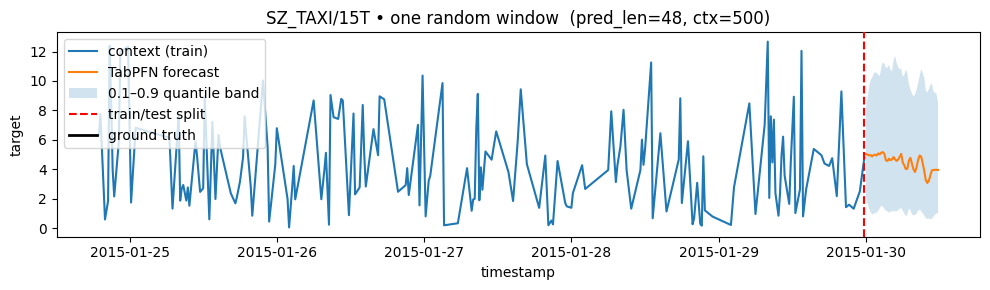

In [53]:
# --- One-cell demo: sample a random test window, normalize it, forecast, and plot (+ GT on top) ---
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gift_eval.evaluate import construct_evaluation_data
from gift_eval.tabpfn_ts_wrapper import TabPFNTSPredictor, TabPFNMode

# ---- knobs ----
dataset_name = "SZ_TAXI/15T"
dataset_storage_path = Path("/home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/data/")  # change if needed
context_length = 500
batch_size = 1024
random.seed(0)

# 1) Build evaluation data for a single term (short)
[(sub_dataset, ds_meta)] = construct_evaluation_data(
    dataset_name=dataset_name,
    dataset_storage_path=dataset_storage_path,
    terms=["short"],
)

pred_len = sub_dataset.prediction_length
ds_freq  = sub_dataset.freq

# 2) Init the TabPFN TS predictor
predictor = TabPFNTSPredictor(
    ds_prediction_length=pred_len,
    ds_freq=ds_freq,
    tabpfn_mode=TabPFNMode.LOCAL,
    context_length=context_length,
    debug=False,
    batch_size=batch_size,
)

# 3) Reservoir-sample ONE entry from the test set
selected = None
for i, entry in enumerate(sub_dataset.test_data):
    if random.random() < 1.0 / (i + 1):
        selected = entry
assert selected is not None, "Could not sample a test series."

# 4) Normalize: unwrap tuple -> dict, set missing freq, coerce start to Period
if isinstance(selected, tuple):
    selected = next((el for el in selected if isinstance(el, dict)), selected[0])

if "freq" not in selected:
    selected["freq"] = ds_freq

if not isinstance(selected["start"], pd.Period):
    selected["start"] = pd.Period(selected["start"], freq=ds_freq)

# 5) Use the same preprocessing as the evaluator
train_tsdf, test_tsdf = predictor._preprocess_test_data([selected])

# 6) Run TabPFN on this single window
pred_tsdf = predictor.tabpfn_predictor.predict(train_tsdf, test_tsdf)

# 7) Plot: context used vs. forecast horizon (median + band if available), then GT in black on top
item_id = pred_tsdf.item_ids[0]
train_item = train_tsdf.xs(item_id, level="item_id")
pred_item  = pred_tsdf.xs(item_id, level="item_id")

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# context and prediction
ax.plot(train_item.index, train_item["target"], label="context (train)", zorder=2)
ax.plot(pred_item.index, pred_item["target"], label="TabPFN forecast", zorder=3)

# shaded band between the smallest/largest quantiles available
q_cols = sorted([c for c in pred_item.columns if c != "target"], key=float)
if q_cols:
    ax.fill_between(
        pred_item.index, pred_item[q_cols[0]], pred_item[q_cols[-1]],
        alpha=0.2, label=f"{q_cols[0]}–{q_cols[-1]} quantile band", zorder=1
    )

# vertical split line
ax.axvline(train_item.index[-1], ls="--", c="r", label="train/test split", zorder=4)

# --- Ground truth reconstruction and overlay (BLACK, ALWAYS ON TOP) ---
start_ts = selected["start"].to_timestamp()  # Period -> Timestamp
full_idx = pd.date_range(start=start_ts, periods=len(selected["target"]), freq=ds_freq)
full_series = pd.Series(selected["target"], index=full_idx)

cutoff = train_item.index[-1]
gt = full_series.loc[full_series.index > cutoff].iloc[:pred_len]
# align to prediction index just in case
gt = gt.reindex(pred_item.index)

ax.plot(gt.index, gt.values, color="black", linewidth=2.0, label="ground truth", zorder=10)

ax.set_title(f"{dataset_name} • one random window  (pred_len={pred_len}, ctx={context_length})")
ax.set_xlabel("timestamp"); ax.set_ylabel("target"); ax.legend(loc="upper left")
plt.tight_layout(); plt.show()


In [49]:
gt.values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

/home/dplaskow/pfn-gift-eval/tabpfn-time-series/tabpfn_time_series/features/feature_transformer.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsdf = pd.concat([train_tsdf, test_tsdf])
GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


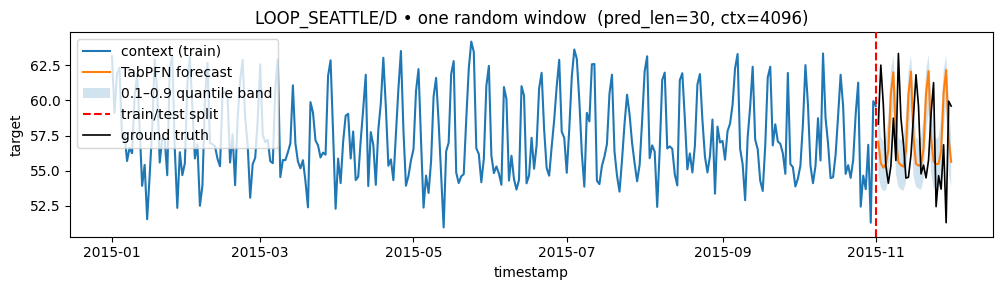

In [57]:
# --- One-cell demo with robust GT extraction + black-on-top overlay ---
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gift_eval.evaluate import construct_evaluation_data
from gift_eval.tabpfn_ts_wrapper import TabPFNTSPredictor, TabPFNMode


# ---- knobs ----
dataset_name = "LOOP_SEATTLE/D"
dataset_storage_path = Path("/home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/data/")  # change if needed
context_length = 4096
batch_size = 1024
random.seed(0)

# 1) Build evaluation data for a single term (short)
[(sub_dataset, ds_meta)] = construct_evaluation_data(
    dataset_name=dataset_name,
    dataset_storage_path=dataset_storage_path,
    terms=["short"],
)

pred_len = sub_dataset.prediction_length
ds_freq  = sub_dataset.freq

# 2) Init the TabPFN TS predictor
predictor = TabPFNTSPredictor(
    ds_prediction_length=pred_len,
    ds_freq=ds_freq,
    tabpfn_mode=TabPFNMode.LOCAL,
    context_length=context_length,
    debug=False,
    batch_size=batch_size,
)

# 3) Reservoir-sample ONE entry from the test set (keep the original "raw" selection too)
selected_raw = None
for i, entry in enumerate(sub_dataset.test_data):
    if random.random() < 1.0 / (i + 1):
        selected_raw = entry
assert selected_raw is not None, "Could not sample a test series."

# 4) Normalize: unwrap tuple -> dict (model input), set missing freq, coerce start to Period
selected = selected_raw
if isinstance(selected, tuple):
    selected = next((el for el in selected if isinstance(el, dict)), selected[0])

if "freq" not in selected:
    selected["freq"] = ds_freq
if not isinstance(selected["start"], pd.Period):
    selected["start"] = pd.Period(selected["start"], freq=ds_freq)

# 5) Preprocess and predict
train_tsdf, test_tsdf = predictor._preprocess_test_data([selected])
pred_tsdf = predictor.tabpfn_predictor.predict(train_tsdf, test_tsdf)

item_id = pred_tsdf.item_ids[0]
train_item = train_tsdf.xs(item_id, level="item_id")
pred_item  = pred_tsdf.xs(item_id, level="item_id")

# 6) Try hard to extract UNMASKED ground-truth horizon from the original tuple
def extract_gt_from_raw(raw_obj, pred_len):
    """
    Best-effort: look for y_true/future_target/etc. inside the sampled record.
    Falls back to the last pred_len of 'target' if nothing better is found.
    Returns a 1D np.ndarray or None.
    """
    candidate = None

    # helper to validate a numeric 1D array (not all-NaN)
    def ok(arr):
        if arr is None: return False
        a = np.asarray(arr, dtype=float).ravel()
        return a.size >= pred_len and not np.all(np.isnan(a))

    look_in = []
    if isinstance(raw_obj, tuple):
        look_in.extend(list(raw_obj))
    else:
        look_in.append(raw_obj)

    # 1) search dict-like payloads for common GT keys
    gt_keys = ["y_true", "y", "future_target", "gt", "ground_truth", "target_future"]
    for el in look_in:
        if isinstance(el, dict):
            for k in gt_keys:
                if k in el and ok(el[k]):
                    candidate = np.asarray(el[k], dtype=float).ravel()[-pred_len:]
                    break
        if candidate is not None:
            break

    # 2) search any array-like element of the tuple that smells like a horizon
    if candidate is None:
        for el in look_in:
            if isinstance(el, (list, tuple, np.ndarray, pd.Series)):
                arr = np.asarray(el, dtype=float).ravel()
                if ok(arr):
                    candidate = arr[-pred_len:]
                    break

    # 3) final fallback: use the end of the visible target (may be masked -> NaNs)
    if candidate is None:
        tgt = None
        ref = None
        for el in look_in:
            if isinstance(el, dict) and "target" in el:
                tgt = el["target"]; ref = el
                break
        if tgt is not None:
            candidate = np.asarray(tgt, dtype=float).ravel()[-pred_len:]

    return candidate

gt_vals = extract_gt_from_raw(selected_raw, pred_len)
# Align by position to the prediction index (avoids timestamp mismatch issues)
gt_index = pred_item.index[: len(gt_vals)] if gt_vals is not None else pred_item.index[:0]

# 7) Plot: context, prediction (with quantile band), and GT (black) on top
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(train_item.index, train_item["target"], label="context (train)", zorder=2)
ax.plot(pred_item.index, pred_item["target"], label="TabPFN forecast", zorder=3)

# shaded band between the smallest/largest quantiles available
q_cols = sorted([c for c in pred_item.columns if c != "target"], key=float)
if q_cols:
    ax.fill_between(
        pred_item.index,
        pred_item[q_cols[0]],
        pred_item[q_cols[-1]],
        alpha=0.2,
        label=f"{q_cols[0]}–{q_cols[-1]} quantile band",
        zorder=1,
    )

# split line
ax.axvline(train_item.index[-1], ls="--", c="r", label="train/test split", zorder=4)

# Ground truth overlay (BLACK, always on top). Show a small note if it's missing/NaN.
if gt_vals is not None and not np.all(np.isnan(gt_vals)):
    ax.plot(gt_index, gt_vals[: len(gt_index)], color="black", linewidth=1.2,
            label="ground truth", zorder=10)
else:
    ax.text(0.01, 0.98, "Ground truth unavailable in sample (masked).",
            transform=ax.transAxes, va="top", ha="left", fontsize=9)

ax.set_title(f"{dataset_name} • one random window  (pred_len={pred_len}, ctx={context_length})")
ax.set_xlabel("timestamp"); ax.set_ylabel("target"); ax.legend(loc="upper left")
plt.tight_layout(); plt.show()
